#  _Decision Tree Model for Binary classification_

## _Problem_

Identify products at risk of backorder before the event occurs so the business has time to react. 

#### _Loading the required libraries_

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn import tree


from sklearn.model_selection import GridSearchCV

import graphviz
#!conda install --yes python-graphviz
#!conda install --yes graphviz
import pydotplus
import pydot
#from PIL import Image

import matplotlib.pyplot as plt

### _Data_

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product
    
    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.
    
         Yes or 1 : Product backordered

         No or 0  : Product not backordered

In [2]:
data = pd.read_csv("BackOrders.csv")
data

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61584,1397275,6,8.0,0,24,24,24,0,7,9,...,0,0.98,0.98,0,No,No,No,Yes,No,No
61585,3072139,130,2.0,0,40,80,140,18,108,230,...,0,0.51,0.28,0,No,No,No,Yes,No,No
61586,1909363,135,9.0,0,0,0,0,10,40,65,...,0,1.00,0.99,0,No,No,Yes,Yes,No,No
61587,1845783,63,NaN,0,0,0,0,452,1715,3425,...,0,-99.00,-99.00,1,No,No,No,No,No,Yes


#### Loading the data

In [3]:
data.went_on_backorder.value_counts()

No     50296
Yes    11293
Name: went_on_backorder, dtype: int64

#### Understand the Data

See the No. row and columns

In [4]:
data.shape

(61589, 23)

Display the columns

In [5]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

See the top rows of the data

In [6]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe

In [7]:
data.describe(include ='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [8]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

In [9]:
data.describe(include='object')

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,61589,61589,61589,61589,61589,61589,61589
unique,2,2,2,2,2,2,2
top,No,No,No,No,Yes,No,No
freq,61509,48145,61577,53792,59303,61569,50296


#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [10]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [11]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [12]:
np.size(np.unique(data.sku, return_counts=True)[0])

61589

In [13]:
data.drop('sku',axis=1,inplace=True)
#inplace = I don't have to reassign a data, So it does it from original database. 

In [14]:
data.shape

(61589, 22)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [15]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [16]:
print (data.shape)

(61589, 22)


In [17]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data.dropna(axis=0,inplace=True)

In [18]:
print(data.isnull().sum())
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
(58186, 22)


In [19]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object') (58186, 22)


#### Converting Categorical to Numeric

    'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables

Creating dummy variables.

    If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [20]:
categorial_Attributes = data.select_dtypes(include=['category']).columns
categorial_Attributes

Index(['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
       'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [21]:
data = pd.get_dummies(columns=categorial_Attributes, data=data, prefix=categorial_Attributes, prefix_sep="_", drop_first=True)

In [22]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


In [23]:
#Expanding the Output display to see more columns of pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [24]:
data.describe(include='all')

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,went_on_backorder_Yes
count,58186.000000,58186.000000,58186.000000,5.818600e+04,5.818600e+04,5.818600e+04,58186.000000,58186.000000,5.818600e+04,5.818600e+04,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000,58186.000000
mean,281.245987,7.559619,31.338123,1.780929e+02,3.313014e+02,4.771002e+02,45.347575,153.180610,2.888281e+02,4.289081e+02,43.424415,1.696766,-0.840541,-0.416599,1.259977,0.001358,0.195837,0.000206,0.124944,0.975080,0.000223,0.188516
std,4321.329801,6.498952,814.665767,5.438487e+03,1.005456e+04,1.460902e+04,1408.074630,5360.176586,9.101474e+03,1.304183e+04,979.291691,43.525034,12.567315,10.786604,30.819641,0.036822,0.396847,0.014360,0.330658,0.155883,0.014946,0.391127
min,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.680000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,2.000000,4.000000e+00,6.000000e+00,0.000000,0.000000,0.830000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,55.000000,8.000000,0.000000,1.400000e+01,2.800000e+01,4.200000e+01,6.000000,18.000000,3.600000e+01,5.400000e+01,4.000000,0.000000,0.970000,0.950000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,673445.000000,52.000000,170976.000000,1.126656e+06,2.094336e+06,3.062016e+06,295197.000000,934593.000000,1.799099e+06,2.631590e+06,192978.000000,7392.000000,1.000000,1.000000,2999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Target attribute distribution

In [25]:
pd.value_counts(data['went_on_backorder_Yes'].values)

0    47217
1    10969
dtype: int64

#### Split the data in to train and test

sklearn.model_selection.train_test_split

    Split arrays or matrices into random train and test subsets

In [26]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values,\
        data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [27]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33067
1     7663
dtype: int64
0    14150
1     3306
dtype: int64


### _Building a  Basic Decision Tree Model_

In [28]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [29]:
clf.feature_importances_

array([3.12941672e-01, 3.21069250e-02, 3.19368074e-02, 9.48159902e-02,
       2.57037251e-02, 1.10432242e-01, 6.86324317e-02, 3.76833066e-02,
       4.87896787e-02, 4.86144741e-02, 2.85296784e-02, 7.36878283e-03,
       5.44819356e-02, 6.51562792e-02, 1.01558601e-02, 7.46737656e-05,
       1.10954736e-02, 0.00000000e+00, 9.96561097e-03, 1.51445251e-03,
       0.00000000e+00])

In [30]:
data.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes', 'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes', 'rev_stop_Yes', 'went_on_backorder_Yes'], dtype='object')

In [31]:
features = data.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
pd.DataFrame([data.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,national_inv,forecast_9_month,forecast_3_month,sales_1_month,perf_12_month_avg,perf_6_month_avg,sales_6_month,sales_9_month,sales_3_month,lead_time,in_transit_qty,min_bank,forecast_6_month,deck_risk_Yes,local_bo_qty,ppap_risk_Yes,pieces_past_due,stop_auto_buy_Yes,potential_issue_Yes,oe_constraint_Yes,rev_stop_Yes
1,0.312942,0.110432,0.094816,0.0686324,0.0651563,0.0544819,0.0487897,0.0486145,0.0376833,0.0321069,0.0319368,0.0285297,0.0257037,0.0110955,0.0101559,0.00996561,0.00736878,0.00151445,7.46738e-05,0,0


In [32]:
importances

array([3.12941672e-01, 3.21069250e-02, 3.19368074e-02, 9.48159902e-02,
       2.57037251e-02, 1.10432242e-01, 6.86324317e-02, 3.76833066e-02,
       4.87896787e-02, 4.86144741e-02, 2.85296784e-02, 7.36878283e-03,
       5.44819356e-02, 6.51562792e-02, 1.01558601e-02, 7.46737656e-05,
       1.10954736e-02, 0.00000000e+00, 9.96561097e-03, 1.51445251e-03,
       0.00000000e+00])

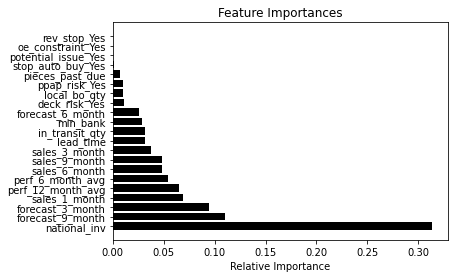

In [33]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### _Test Performance_

In [34]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [35]:
print(train_pred[:5])
print(test_pred[:5])

[0 1 1 0 0]
[0 0 0 0 1]


#### _Getting evaluation metrics and evaluating model performance_

In [36]:
# Set up Train and Test Confusion Matrices
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[33047    20]
 [   69  7594]]
[[13193   957]
 [  770  2536]]


#### _Calculate Accuracy, True Positive Rate and True Negative Rates_

In [37]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9993951673874255
Train TPR:  0.9909956935925878
Train Accuracy:  0.9978148784679597


In [38]:
# It's Overfitting quite bad.because we have grown tree all the way in train data-set

In [39]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] + confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] + confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9323674911660778
Test TPR:  0.7670901391409558
Test Accuracy:  0.9010655362053163


In [40]:
# Here, recall is pretty bad in test data-set as compared to train data-set because of data-imbalance.If I call every sample 
# as a minority class, I basically get a very good accuaracy that why recall becomes important.

#### Building Decision Tree Model using Variable Importance

In [41]:
indices

array([ 0,  5,  3,  6, 13, 12,  8,  9,  7,  1,  2, 10,  4, 16, 14, 18, 11,
       19, 15, 17, 20], dtype=int64)

In [42]:
#Rebuild Model with the top 10 important variables

#clf = tree.DecisionTreeClassifier(max_depth=3)
#clf = clf.fit(X_train, y_train)

In [44]:
#train_pred = clf.predict(X_train[:,select])
#test_pred = clf.predict(X_test[:,select])

In [45]:
#print(train_pred[:5])
#print(test_pred[:5])

#### Getting evaluation metrics and evaluating model performance

In [46]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[33047    20]
 [   69  7594]]
[[13193   957]
 [  770  2536]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [47]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9993951673874255
Train TPR:  0.9909956935925878
Train Accuracy:  0.9978148784679597


In [48]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9323674911660778
Test TPR:  0.7670901391409558
Test Accuracy:  0.9010655362053163


### _How do we arrive at the best tree depth for this data?_

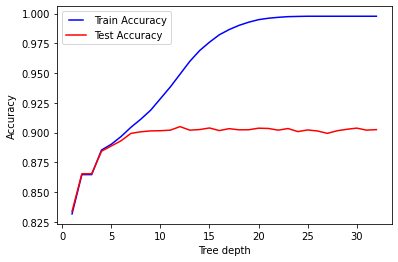

In [49]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = tree.DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    confusion_matrix_train = confusion_matrix(y_train, train_pred)
    Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
    train_results.append(Accuracy_Train)
    
    test_pred = dt.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_test, test_pred)
    Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
    test_results.append(Accuracy_Test)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results,'b', label='Train Accuracy')
line2, = plt.plot(max_depths, test_results,'r', label='Test Accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

### _Is there a better way to tune Hyper-parameters?_

<br />

_Lets list the hyper-parameters for Decision Trees:_

**criterion** : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.


**max_depth** : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


**min_samples_split** : int, float, optional (default=2)
The minimum number of samples required to split an internal node:
If int, then consider min_samples_split as the minimum number.
If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.



**min_samples_leaf** : int, float, optional (default=1)
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
If int, then consider min_samples_leaf as the minimum number.
If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

**max_leaf_nodes** : int or None, optional (default=None)
Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.


In [50]:
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

In [51]:
# setup GridSearchCV and fit model
dt = tree.DecisionTreeClassifier()
clf2 = GridSearchCV(dt, param_grid, cv=2)
clf2.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]})

In [52]:
clf2.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': None,
 'min_samples_leaf': 5,
 'min_samples_split': 20}

In [53]:
clf2.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20)

In [54]:
train_pred = clf2.predict(X_train)
test_pred = clf2.predict(X_test)

In [55]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR:  0.9568754347234403
Train TPR:  0.7711079211796946
Train Accuracy:  0.9219248711023815
Test TNR:  0.9443109540636042
Test TPR:  0.7150635208711433
Test Accuracy:  0.9008936755270394


## _Visualizing Decision Trees_

In [56]:
#dot_data = tree.export_graphviz(clf2.best_estimator_, out_file=None, 
#                                feature_names=data.drop(['went_on_backorder_Yes'], axis = 1).columns,
#                                class_names=['No','Yes'], 
#                                filled=True, rounded=True, special_characters=True) 
#graph = graphviz.Source(dot_data) 
#graph
#graph.render("back_orders")